In [1]:
"""
Train a YOLOv12 model with train / val / test splits.
Make sure you've installed ultralytics inside your virtual environment:
    pip install ultralytics
"""

from ultralytics import YOLO

# ────────────────────────────────────────────────────────────────
# 1️⃣ Load the model (YOLOv12n as example — you can pick s, m, l, etc.)
# ────────────────────────────────────────────────────────────────
# Use the YOLOv12 large pretrained weights (or point to a local "yolov12l.pt" if you have it)
model = YOLO("yolov10s.yaml")

# ────────────────────────────────────────────────────────────────
# 2️⃣ Define your dataset YAML path
# The YAML should include train, val, and test like this:
#
# train: dataset/train/images
# val: dataset/val/images
# test: dataset/test/images
# nc: 3
# names: [class1, class2, class3]
# ────────────────────────────────────────────────────────────────
DATA_YAML = "datasets\\data.yaml"   # ← change this to your actual dataset yaml path

# ────────────────────────────────────────────────────────────────
# 3️⃣ Train the model
# ────────────────────────────────────────────────────────────────
model.train(
    data=DATA_YAML, #model that you want to use
    epochs=100, #number of runs
    imgsz=1024,#image resolution
    batch=8,#numebr of images per
    device='0',   # ← use CPU instead of GPU
    workers=4 #number of threads
)

# ────────────────────────────────────────────────────────────────
# 4️⃣ Validate on the val set (automatically done during training)
# But you can explicitly validate again if you want
# ────────────────────────────────────────────────────────────────
model.val(data=DATA_YAML, split='val')

# ────────────────────────────────────────────────────────────────
# 5️⃣ Evaluate on the test set (AFTER training!)
# This uses the same model, but different data split
# ────────────────────────────────────────────────────────────────
model.val(data=DATA_YAML, split='test')

# ────────────────────────────────────────────────────────────────
# 6️⃣ (Optional) Export the trained model to other formats
# ────────────────────────────────────────────────────────────────
model.export(format="onnx")   # can also use "torchscript", "coreml", etc.

print("✅ Training, validation, and testing completed successfully!")


Ultralytics 8.3.208  Python-3.12.3 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=datasets\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10s.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train7, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plo

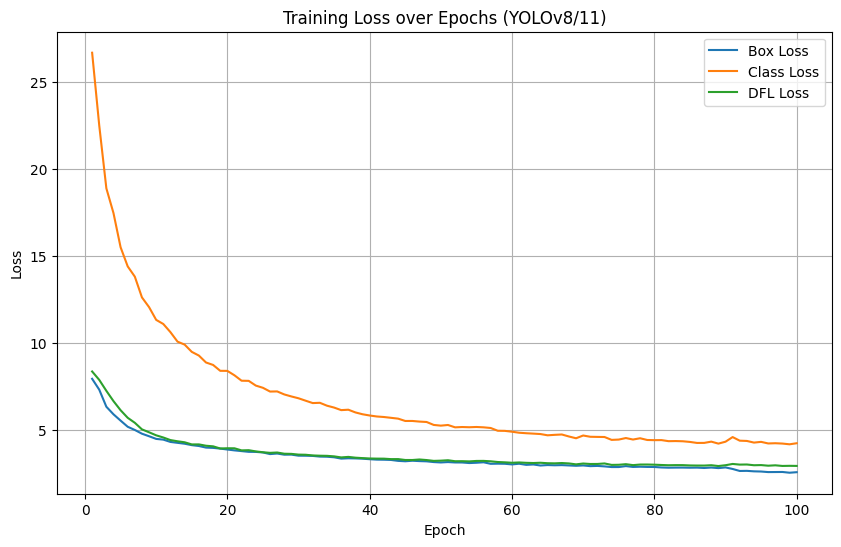

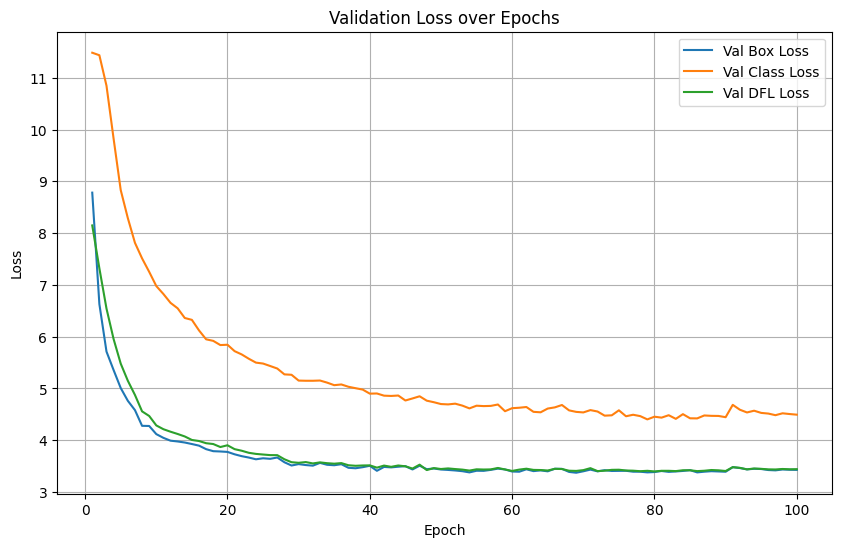

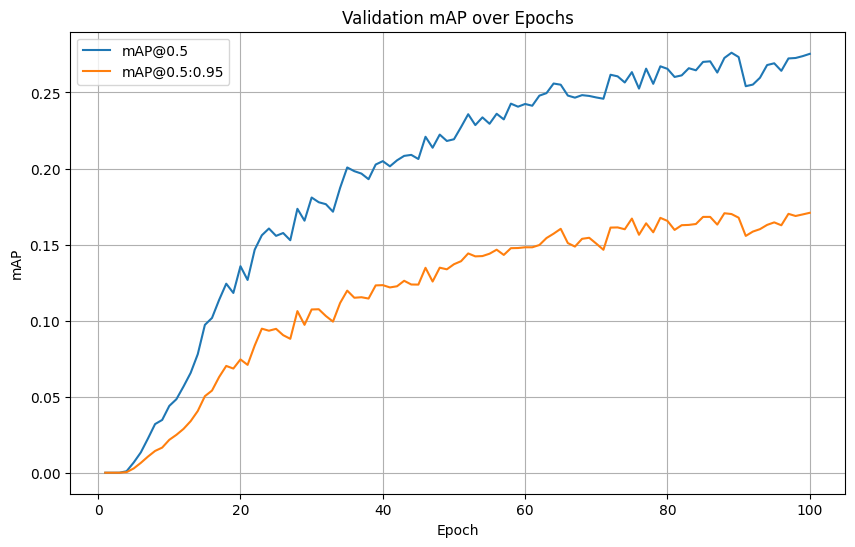

In [9]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

# Load results
results = pd.read_csv("runs/detect/train7/results.csv")

# Plot training losses
plt.figure(figsize=(10,6))
plt.plot(results["epoch"], results["train/box_loss"], label="Box Loss")
plt.plot(results["epoch"], results["train/cls_loss"], label="Class Loss")
plt.plot(results["epoch"], results["train/dfl_loss"], label="DFL Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs (YOLOv8/11)")
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10,6))
plt.plot(results["epoch"], results["val/box_loss"], label="Val Box Loss")
plt.plot(results["epoch"], results["val/cls_loss"], label="Val Class Loss")
plt.plot(results["epoch"], results["val/dfl_loss"], label="Val DFL Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Plot mAP metrics
plt.figure(figsize=(10,6))
plt.plot(results["epoch"], results["metrics/mAP50(B)"], label="mAP@0.5")
plt.plot(results["epoch"], results["metrics/mAP50-95(B)"], label="mAP@0.5:0.95")
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.title("Validation mAP over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from rfdetr import RFDETRBase

# 1️⃣ Create a model instance
model = RFDETRBase(model_size="large") 

# 2️⃣ Define your dataset path
dataset_dir = "dataset-coco"

history = []
def log_epoch(data):
    # Retrieve the epoch and the main mAP metric
    epoch = data.get("epoch", "?")
    # RFDETR's overall mean Average Precision (mAP)
    mAP = data.get("mAP") or data.get("val_map") or data.get("bbox_mAP") or "N/A"
    
    # Print the essential information
    print(f" Epoch {epoch} | mAP (Accuracy): {mAP}")
    
    history.append(data)

model.callbacks["on_fit_epoch_end"].append(log_epoch)

# Configure the path where all checkpoints will be saved
output_directory = "./checkpoints"

# 4️⃣ Train the model with reliable saving
model.train(
    dataset_dir=dataset_dir,
    epochs=50,
    batch_size=8,
    lr=1e-4,
    output_dir=output_directory,     # REQUIRED: Where to save the files
    checkpoint_interval=1,
    save_every_epoch=True,           # RECOMMENDED: Saves a full state after every epoch
)

Loading pretrain weights
Unable to initialize TensorBoard. Logging is turned off for this session.  Run 'pip install tensorboard' to enable logging.
Not using distributed mode
git:
  sha: d84d33e51e9b6420eb5757e0965e2f8fa8a47d8f, status: has uncommited changes, branch: main

Namespace(num_classes=112, grad_accum_steps=4, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=8, weight_decay=0.0001, epochs=50, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-base.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[2, 5, 8, 11], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False

Epoch: [0]  [ 0/51]  eta: 0:20:49  lr: 0.000100  class_error: 100.00  loss: 10.3090 (10.3090)  loss_ce: 1.2645 (1.2645)  loss_bbox: 0.4571 (0.4571)  loss_giou: 0.8355 (0.8355)  loss_ce_0: 1.2959 (1.2959)  loss_bbox_0: 0.4511 (0.4511)  loss_giou_0: 0.8298 (0.8298)  loss_ce_1: 1.2963 (1.2963)  loss_bbox_1: 0.4542 (0.4542)  loss_giou_1: 0.8156 (0.8156)  loss_ce_enc: 1.2681 (1.2681)  loss_bbox_enc: 0.4780 (0.4780)  loss_giou_enc: 0.8629 (0.8629)  loss_ce_unscaled: 1.2645 (1.2645)  class_error_unscaled: 100.0000 (100.0000)  loss_bbox_unscaled: 0.0914 (0.0914)  loss_giou_unscaled: 0.4178 (0.4178)  cardinality_error_unscaled: 3897.8750 (3897.8750)  loss_ce_0_unscaled: 1.2959 (1.2959)  loss_bbox_0_unscaled: 0.0902 (0.0902)  loss_giou_0_unscaled: 0.4149 (0.4149)  cardinality_error_0_unscaled: 3897.8750 (3897.8750)  loss_ce_1_unscaled: 1.2963 (1.2963)  loss_bbox_1_unscaled: 0.0908 (0.0908)  loss_giou_1_unscaled: 0.4078 (0.4078)  cardinality_error_1_unscaled: 3897.8750 (3897.8750)  loss_ce_enc_un

Test:  [ 0/23]  eta: 0:07:08  class_error: 82.86  loss: 7.4910 (7.4910)  loss_ce: 1.1719 (1.1719)  loss_bbox: 0.1188 (0.1188)  loss_giou: 0.5675 (0.5675)  loss_ce_0: 1.1641 (1.1641)  loss_bbox_0: 0.1236 (0.1236)  loss_giou_0: 0.6049 (0.6049)  loss_ce_1: 1.1719 (1.1719)  loss_bbox_1: 0.1212 (0.1212)  loss_giou_1: 0.5730 (0.5730)  loss_ce_enc: 1.1250 (1.1250)  loss_bbox_enc: 0.1258 (0.1258)  loss_giou_enc: 0.6233 (0.6233)  loss_ce_unscaled: 1.1719 (1.1719)  class_error_unscaled: 82.8571 (82.8571)  loss_bbox_unscaled: 0.0238 (0.0238)  loss_giou_unscaled: 0.2838 (0.2838)  cardinality_error_unscaled: 295.6250 (295.6250)  loss_ce_0_unscaled: 1.1641 (1.1641)  loss_bbox_0_unscaled: 0.0247 (0.0247)  loss_giou_0_unscaled: 0.3024 (0.3024)  cardinality_error_0_unscaled: 295.6250 (295.6250)  loss_ce_1_unscaled: 1.1719 (1.1719)  loss_bbox_1_unscaled: 0.0242 (0.0242)  loss_giou_1_unscaled: 0.2865 (0.2865)  cardinality_error_1_unscaled: 295.6250 (295.6250)  loss_ce_enc_unscaled: 1.1250 (1.1250)  loss_

In [ ]:
#for resuming training later:
from rfdetr import RFDETRBase

# 1️⃣ Create a model instance
model = RFDETRBase(model_size="large") 

# 2️⃣ Define your dataset path
dataset_dir = "dataset-coco"

history = []
def log_epoch(data):
    # Retrieve the epoch and the main mAP metric
    epoch = data.get("epoch", "?")
    # RFDETR's overall mean Average Precision (mAP)
    mAP = data.get("mAP") or data.get("val_map") or data.get("bbox_mAP") or "N/A"
    
    # Print the essential information
    print(f"✅ Epoch {epoch} | mAP (Accuracy): {mAP}")
    
    history.append(data)

model.callbacks["on_fit_epoch_end"].append(log_epoch)

# Configure the path where all checkpoints will be saved
output_directory = "./checkpoints"

# 4️⃣ Resume the model from the checkpoint
checkpoint_file = "./checkpoints/checkpoint0053.pth"

model.train(
    dataset_dir=dataset_dir,
    epochs=100,                       # Set the total epochs again (e.g., up to 50)
    batch_size=6,
    lr=1e-4,
    output_dir="./checkpoints", 
    save_every_epoch=True,
    checkpoint_interval=1,        # Save every epoch
    resume=checkpoint_file,          # Load the weights, optimizer state, and epoch number
)


Loading pretrain weights
TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir ./checkpoints' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: fb4310081b2843d3ef1427448108e5453ee05169, status: has uncommited changes, branch: main

Namespace(num_classes=112, grad_accum_steps=4, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=6, weight_decay=0.0001, epochs=100, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-base.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[2, 5, 8, 11], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pr

Epoch: [54]  [ 0/68]  eta: 0:26:14  lr: 0.000100  class_error: 0.00  loss: 2.5536 (2.5536)  loss_ce: 0.3340 (0.3340)  loss_bbox: 0.0698 (0.0698)  loss_giou: 0.1999 (0.1999)  loss_ce_0: 0.3886 (0.3886)  loss_bbox_0: 0.0707 (0.0707)  loss_giou_0: 0.1928 (0.1928)  loss_ce_1: 0.3253 (0.3253)  loss_bbox_1: 0.0701 (0.0701)  loss_giou_1: 0.1933 (0.1933)  loss_ce_enc: 0.4033 (0.4033)  loss_bbox_enc: 0.0831 (0.0831)  loss_giou_enc: 0.2228 (0.2228)  loss_ce_unscaled: 0.3340 (0.3340)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.0140 (0.0140)  loss_giou_unscaled: 0.1000 (0.1000)  cardinality_error_unscaled: 3894.6667 (3894.6667)  loss_ce_0_unscaled: 0.3886 (0.3886)  loss_bbox_0_unscaled: 0.0141 (0.0141)  loss_giou_0_unscaled: 0.0964 (0.0964)  cardinality_error_0_unscaled: 3879.8335 (3879.8335)  loss_ce_1_unscaled: 0.3253 (0.3253)  loss_bbox_1_unscaled: 0.0140 (0.0140)  loss_giou_1_unscaled: 0.0967 (0.0967)  cardinality_error_1_unscaled: 3887.3335 (3887.3335)  loss_ce_enc_unscaled:

Test:  [ 0/30]  eta: 0:09:49  class_error: 54.55  loss: 7.8272 (7.8272)  loss_ce: 1.2422 (1.2422)  loss_bbox: 0.1108 (0.1108)  loss_giou: 0.5283 (0.5283)  loss_ce_0: 1.3828 (1.3828)  loss_bbox_0: 0.1133 (0.1133)  loss_giou_0: 0.5407 (0.5407)  loss_ce_1: 1.2812 (1.2812)  loss_bbox_1: 0.1106 (0.1106)  loss_giou_1: 0.5193 (0.5193)  loss_ce_enc: 1.3359 (1.3359)  loss_bbox_enc: 0.1194 (0.1194)  loss_giou_enc: 0.5428 (0.5428)  loss_ce_unscaled: 1.2422 (1.2422)  class_error_unscaled: 54.5455 (54.5455)  loss_bbox_unscaled: 0.0222 (0.0222)  loss_giou_unscaled: 0.2642 (0.2642)  cardinality_error_unscaled: 295.3333 (295.3333)  loss_ce_0_unscaled: 1.3828 (1.3828)  loss_bbox_0_unscaled: 0.0227 (0.0227)  loss_giou_0_unscaled: 0.2703 (0.2703)  cardinality_error_0_unscaled: 294.8333 (294.8333)  loss_ce_1_unscaled: 1.2812 (1.2812)  loss_bbox_1_unscaled: 0.0221 (0.0221)  loss_giou_1_unscaled: 0.2596 (0.2596)  cardinality_error_1_unscaled: 290.5000 (290.5000)  loss_ce_enc_unscaled: 1.3359 (1.3359)  loss_

In [1]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


2.5.1+cu121
12.1
True
NVIDIA GeForce RTX 3070 Laptop GPU


In [10]:
import json, pandas as pd

records = []
with open("./checkpoints/log.txt", "r", encoding="utf-8") as f:
    for line in f:
        try:
            records.append(json.loads(line))
        except Exception as e:
            print("❌ Skipped malformed line:", e)

# Save all top-level metrics (losses, errors, etc.)
df_main = pd.DataFrame(records)
df_main.to_csv("clean_metrics.csv", index=False)
print("✅ Saved global metrics to clean_metrics.csv")

rows = []
for rec in records:
    epoch = rec.get("epoch", None)
    for section in ["test_results_json", "ema_test_results_json"]:
        if section in rec:
            for cls in rec[section]["class_map"]:
                row = {
                    "epoch": epoch,
                    "source": section,
                    "class": cls["class"],
                    "map@50:95": cls["map@50:95"],
                    "map@50": cls["map@50"],
                    "precision": cls["precision"],
                    "recall": cls["recall"]
                }
                rows.append(row)

df_classes = pd.DataFrame(rows)
df_classes.to_csv("class_map.csv", index=False)
print("✅ Saved per-class metrics to class_map.csv")


✅ Saved global metrics to clean_metrics.csv
✅ Saved per-class metrics to class_map.csv


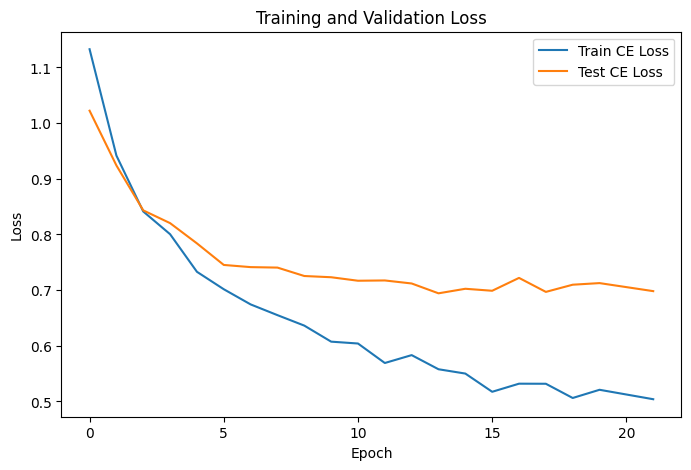

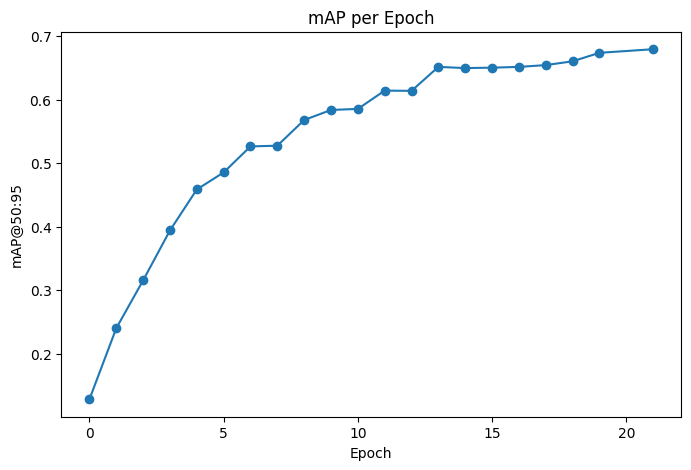

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(df_main["epoch"], df_main["train_loss_ce"], label="Train CE Loss")
plt.plot(df_main["epoch"], df_main["test_loss_ce"], label="Test CE Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend(); plt.show()

plt.figure(figsize=(8,5))
plt.plot(df_main["epoch"], df_main["test_results_json"].apply(lambda x: x["map"]), marker="o")
plt.xlabel("Epoch"); plt.ylabel("mAP@50:95")
plt.title("mAP per Epoch")
plt.show()



In [4]:
import pandas as pd

df = pd.read_csv('./checkpoints/log.txt', delim_whitespace=True)
print(df.columns.tolist())
print(df.head())


['{"train_lr":', '0.0001,', 'train_class_error:', '71.57779947916667,', 'train_loss:', '7.374762778188668,', 'train_loss_ce:', '1.1326775901457842,', 'train_loss_bbox:', '0.17110603244281283,', 'train_loss_giou:', '0.5388733984208575,', 'train_loss_ce_0:', '1.13691919223935,', 'train_loss_bbox_0:', '0.17250816012714423,', 'train_loss_giou_0:', '0.534629305788115,', 'train_loss_ce_1:', '1.125200769480537,', 'train_loss_bbox_1:', '0.1720924692995408,', 'train_loss_giou_1:', '0.5359491092317245,', 'train_loss_ce_enc:', '1.1153267434999055,', 'train_loss_bbox_enc:', '0.1793400656943228,', 'train_loss_giou_enc:', '0.5601399517526814,', 'train_loss_ce_unscaled:', '1.1326775901457842,.1', 'train_class_error_unscaled:', '71.57779947916667,.1', 'train_loss_bbox_unscaled:', '0.03422120655430298,', 'train_loss_giou_unscaled:', '0.26943669921042873,', 'train_cardinality_error_unscaled:', '3896.6813725490197,', 'train_loss_ce_0_unscaled:', '1.13691919223935,.1', 'train_loss_bbox_0_unscaled:', '0.03

C:\Users\vitya\AppData\Local\Temp\ipykernel_10120\2948080499.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('./checkpoints/log.txt', delim_whitespace=True)


In [ ]:
#sending it to robloflow
from roboflow import Roboflow

rf = Roboflow(api_key="YOUR_API_KEY")
workspace = rf.workspace("YOUR_WORKSPACE")

workspace.deploy_model(
  model_type="yolov8",
  model_path="./runs/train/weights",
  project_ids=["project-1", "project-2", "project-3"],
  model_name="my-custom-model"
)